In [1]:
from os import listdir
import copy
import numpy as np
import pickle as pkl

from sklearn.svm import SVC
from sklearn.decomposition import PCA

from utils import Person, signal_to_spike_refractory

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

The raw data can be found at [this](https://www.dropbox.com/sh/8carj2zuzscsc3d/AAAdfSFKGynvIQD76vvhHOERa?dl=0) dropbox link. Download it (or sync it) and change the path in the next section

In [2]:
# general stuff
fs = 200  # sampling frequency of MYO
VERBOSE = False
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/EMG/'  # change this
dvs_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/DVS/'  # change this
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']
classes_dict = {'pinky': 0, 'elle': 1, 'yo': 2, 'index': 3, 'thumb': 4}
classes_inv = {v: k for k, v in classes_dict.items()}

Load all data into subject obects 

In [3]:
subjects = {}
names = [name for name in listdir(data_dir) if "emg" in name]
last_name = ''
all_emg = []
all_ann = []
for name in sorted(names):
    if ''in name:
        _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
        _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])
        cur_name = "_".join(name.split("_")[:2])
        subjects[cur_name] = Person(cur_name, _emg, _ann, classes=classes)
        if VERBOSE:
            print("Loaded {}: EMG = [{}] // ANN = [{}]".format(cur_name, _emg.shape, len(_ann)))

print("Data Loaded! {} Sessions (should be 63)".format(len(subjects.keys())))

# separates data in correct trial type
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

Data Loaded! 63 Sessions (should be 63)
Done sorting trials!


In [4]:
# just check that all the data is there
for k, v in subjects.items():
    for cc in classes:
        assert(len(v.trials[cc]) == 5)

In [5]:
# CORRECTION DICTIONARY for synchronization and allignment 
corrections = {}
corrections['subject01_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-7, 'cy':0}
corrections['subject01_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-7, 'cy':0}
corrections['subject01_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':0}
corrections['subject02_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':0, 'cy':0}
corrections['subject02_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':0, 'cy':0}
corrections['subject02_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-3, 'cy':0}
corrections['subject03_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-3, 'cy':-3}
corrections['subject03_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-7, 'cy':-3}
corrections['subject03_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':-5}
corrections['subject04_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-0, 'cy':-5}
corrections['subject04_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':5, 'cy':0}
corrections['subject04_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':5, 'cy':0}
corrections['subject05_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-3, 'cy':0}
corrections['subject05_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':-3}
corrections['subject05_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':0, 'cy':-5}
corrections['subject06_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':0, 'cy':0}
corrections['subject06_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-3, 'cy':0}
corrections['subject06_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-10, 'cy':-10}
corrections['subject07_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':-5}
corrections['subject07_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':-5}
corrections['subject07_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':0, 'cy':0}
corrections['subject08_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':0, 'cy':0}
corrections['subject08_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':0}
corrections['subject08_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-10, 'cy':-5}
corrections['subject09_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':0, 'cy':-5}
corrections['subject09_session02'] = {'fs':185, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':-5}
corrections['subject09_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-3, 'cy':-5}
corrections['subject10_session01'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':0}
corrections['subject10_session02'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':-5}
corrections['subject10_session03'] = {'fs':200, 'tg':'base', 'shift':0.0, 'cx':-5, 'cy':-5}
corrections['subject11_session01'] = {'fs':174, 'tg':'single', 'shift':1.0, 'cx':-5, 'cy':10}
corrections['subject11_session02'] = {'fs':169, 'tg':'single', 'shift':0.5, 'cx':-5, 'cy':15}
corrections['subject11_session03'] = {'fs':173, 'tg':'single', 'shift':0.5, 'cx':-8, 'cy':10}
corrections['subject12_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':10}
corrections['subject12_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':10}
corrections['subject12_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':10}
corrections['subject13_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-10, 'cy':20}
corrections['subject13_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':5, 'cy':15}
corrections['subject13_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':10}
corrections['subject14_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':5}
corrections['subject14_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':5}
corrections['subject14_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':8}
corrections['subject15_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-5, 'cy':15}
corrections['subject15_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':15}
corrections['subject15_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-5, 'cy':15}
corrections['subject16_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-10, 'cy':15}
corrections['subject16_session02'] = {'fs':200, 'tg':'single', 'shift':1.0, 'cx':-15, 'cy':15}
corrections['subject16_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-20, 'cy':15}
corrections['subject17_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':7, 'cy':10}
corrections['subject17_session02'] = {'fs':200, 'tg':'double', 'shift':0.5, 'cx':10, 'cy':10}
corrections['subject17_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':15, 'cy':15}
corrections['subject18_session01'] = {'fs':200, 'tg':'single', 'shift':1.0, 'cx':-3, 'cy':-5}
corrections['subject18_session02'] = {'fs':200, 'tg':'double', 'shift':0.5, 'cx':-10, 'cy':-15}
corrections['subject18_session03'] = {'fs':200, 'tg':'triple', 'shift':0.5, 'cx':-10, 'cy':-5}
corrections['subject19_session01'] = {'fs':167, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':20}
corrections['subject19_session02'] = {'fs':173, 'tg':'single', 'shift':0.5, 'cx':-3, 'cy':15}
corrections['subject19_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-3, 'cy':15}
corrections['subject20_session01'] = {'fs':174, 'tg':'single', 'shift':1.5, 'cx':-10, 'cy':10}
corrections['subject20_session02'] = {'fs':176, 'tg':'triple', 'shift':1.0, 'cx':-5, 'cy':0}
corrections['subject20_session03'] = {'fs':174, 'tg':'triple', 'shift':1.0, 'cx':-5, 'cy':5}

corrections['subject21_session01'] = {'fs':200, 'tg':'single', 'shift':1.0, 'cx':0, 'cy':0}
corrections['subject21_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':2, 'cy':-2}
corrections['subject21_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':5, 'cy':5}

print(len(list(corrections.keys())))

63


Now every subject has different fields, each field is a dictionary and the keys are the gestures.
We have the following fields: begs (beginning time of trials), ends (end time of trials), trials (actual myo data)

In [6]:
# this is to find the zero timestepping of the davis
def find_trigger(ts):
    return np.where(np.diff(ts) < 0)[0][0] + 1

# for finding center
def create_frame(x, y, dim=(128, 128)):
    img = np.zeros(dim)
    for _x, _y in zip(x.astype('int32'), y.astype('int32')):
        img[dim[0] - 1 - _x,_y] += 1
    return img 

In [7]:
# just debug
subject = 'subject09_session02'
dvs_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/DVS/'
events = np.load(dvs_dir + subject +'_dvs.npy')
print(events.shape)

corr = corrections[subject]

if corr['tg'] == 'single':
    # SINGLE FIX
    a = np.where(np.diff(events[2]) < 0)[0]
    print(a)
    b = events[2][a[0] + 1:]
    c = np.where(np.diff(b) < 0)[0]
    print(c)
    evs = events[:, a[0] + 1:]
    evs[2, c[0] + 1:] += b[c[0]]
    evs[2] /= 1e3
elif corr['tg'] == 'double':
    # DOUBLE FIX
    a = np.where(np.diff(events[2]) < 0)[0]
    print(a)
    b = events[2][a[0] + 1:]
    c = np.where(np.diff(b) < 0)[0]
    print(c)
    evs = events[:, a[0] + 1:]
    evs[2, c[1] + 1:] += b[c[1]]
    evs[2] /= 1e3
elif corr['tg'] == 'triple':
    # TRIPLE FIX
    a = np.where(np.diff(events[2]) < 0)[0]
    print(a)
    b = events[2][a[1] + 1:]
    c = np.where(np.diff(b) < 0)[0]
    print(c)
    evs = events[:, a[1] + 1:]
    evs[2, c[0] + 1:] += b[c[0]]
    evs[2] /= 1e3
elif corr['tg'] == 'base':
    events = events[:, find_trigger(events[2]):]
    events[2] = events[2] / 1e3
    evs = events

(4, 2477587)


63.15135135135135
64.6972972972973


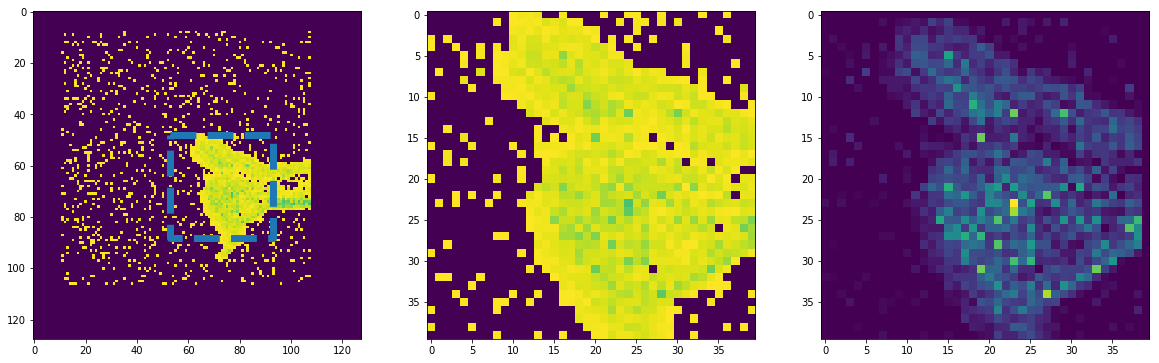

In [8]:
gesture = 'yo'
trial = 2
# load beginning and end 
fs = 185
b = np.array(subjects[subject].begs[gesture][trial]) / fs
e = np.array(subjects[subject].ends[gesture][trial]) / fs

print(b)
print(e)

frame_size = 2
shift = 0.0
beginning = b + shift
ending = beginning + frame_size
# slice
sl = (evs[2] > beginning) & (evs[2] < ending)

img = evs[:, sl]
fig, ax = plt.subplots(1, 3, figsize=(20,10))

sll = (img[1] > 20) & (img[1] < 120) & (img[0] > 10) & (img[0] < 108)

kkk = create_frame(img[1][sll], img[0][sll])
frame = np.uint8(kkk * 255)

M = cv2.moments(frame)
x = int(M["m10"] / M["m00"])
y = int(M["m01"] / M["m00"])

_ = ax[0].imshow(frame)
kk = 20
corr_x = -5
corr_y = -5
ax[0].plot([x - kk - corr_x, x + kk - corr_x, x + kk - corr_x, x - kk - corr_x, x - kk - corr_x], 
           [y  - kk - corr_y, y  - kk - corr_y, y + kk - corr_y, y  + kk - corr_y, y  - kk - corr_y], '--', linewidth=7)

_ = ax[1].imshow(frame[y - kk - corr_y: y + kk - corr_y, x - kk - corr_x:x + kk - corr_x])


a = (img[0] > (x - kk - corr_x)) & (img[0] < (x + kk - corr_x))
b = (img[1] > (127 - y - kk + corr_y)) & (img[1] < (127 - y + kk + corr_y))
xx = img[0][a & b]
yy = img[1][a & b]


ff = create_frame(yy - min(yy), xx - min(xx), dim=(40, 40))
_ = ax[2].imshow(ff)

In [10]:
for subject, data in sorted(subjects.items()):
    if '' in subject:
        events = np.load(dvs_dir + subject +'_dvs.npy')

        corr = corrections[subject]
        if corr['tg'] == 'single':
            # SINGLE FIX
            a = np.where(np.diff(events[2]) < 0)[0]
            b = events[2][a[0] + 1:]
            c = np.where(np.diff(b) < 0)[0]
            evs = events[:, a[0] + 1:]
            evs[2, c[0] + 1:] += b[c[0]]
            evs[2] /= 1e3
        elif corr['tg'] == 'double':
            # DOUBLE FIX
            a = np.where(np.diff(events[2]) < 0)[0]
            b = events[2][a[0] + 1:]
            c = np.where(np.diff(b) < 0)[0]
            evs = events[:, a[0] + 1:]
            evs[2, c[1] + 1:] += b[c[1]]
            evs[2] /= 1e3
        elif corr['tg'] == 'triple':
            # TRIPLE FIX
            a = np.where(np.diff(events[2]) < 0)[0]
            b = events[2][a[1] + 1:]
            c = np.where(np.diff(b) < 0)[0]
            evs = events[:, a[1] + 1:]
            evs[2, c[0] + 1:] += b[c[0]]
            evs[2] /= 1e3
        elif corr['tg'] == 'base':
            events = events[:, find_trigger(events[2]):]
            events[2] = events[2] / 1e3
            evs = events

        events = evs


        for gesture in classes:
            for trial in range(5):
                # load beginning and end 
                b = np.array(data.begs[gesture][trial]) / corr['fs']

                frame_size = 2
                beginning = b + corr['shift']
                ending = beginning + frame_size
                # slice
                sl = (events[2] > beginning) & (events[2] < ending)

                img = events[:, sl]

                sll = (img[1] > 20) & (img[1] < 120) & (img[0] > 10) & (img[0] < 108)

                kkk = create_frame(img[1][sll], img[0][sll])

                frame = np.uint8(kkk * 255)

                M = cv2.moments(frame)
                x = int(M["m10"] / M["m00"])
                y = int(M["m01"] / M["m00"])

                kk = 20
                corr_x = corr['cx']
                corr_y = corr['cy']

                a = (img[0] > (x - kk - corr_x)) & (img[0] < (x + kk - corr_x))
                b = (img[1] > (127 - y - kk + corr_y)) & (img[1] < (127 - y + kk + corr_y))
                xx = img[0][a & b]
                yy = img[1][a & b]
                ts = img[2][a & b]
                pol = img[3][a & b]

                data.x[gesture].append(xx - min(xx))
                data.y[gesture].append(yy - min(yy))
                data.ts[gesture].append(ts - min(ts))
                data.pol[gesture].append(pol)


In [11]:
pkl.dump(subjects, open('relax21_dvs_emg_step1.pkl', 'wb'))

This file contains raw emg and dvs it is useful for the next step of spiking the EMG

In [12]:
subjects = pkl.load(open('relax21_dvs_emg_step1.pkl', 'rb'))

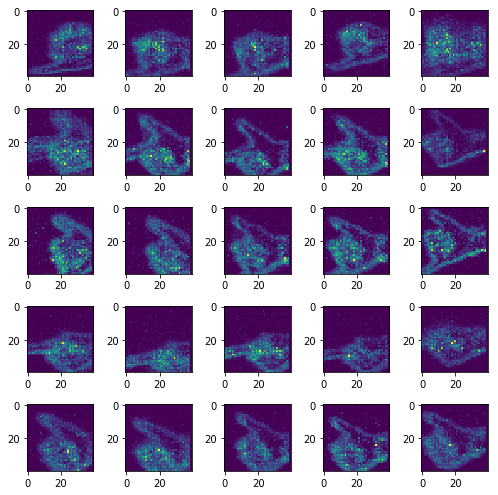

In [36]:
# plot full session
data = subjects['subject04_session02']

fig, ax = plt.subplots(5, 5, figsize=(7, 7))

for i in range(5):
    for j in range(5):
        gesture = classes[i]
        trial = j
        kkk = create_frame(data.y[gesture][trial], data.x[gesture][trial], dim=(40, 40))
        ax[i][j].imshow(kkk)
plt.tight_layout()

# Spiking EMG

In [14]:
interpolation = 3500
# interpolation = 3500 * 10  # for 2x rate
# interpolation = 3500 / 3  # for half rate
refractory = 0.000
th_up = th_dn = 0.05
preprocess = True
preprocess_window = 5
preprocess_exp = 0.3
n_ch = 8
fs = 200
add_noise = False

In [15]:
def true_SNR(sig, snr_range=(-2.5, 2.5)):
    snr = np.random.rand() * (snr_range[1] - snr_range[0]) + snr_range[0]
    sig = unit_power(sig)
    factor = np.sqrt(10 ** (snr / 10.))
    sig *= factor
    return sig


def unit_power(sig):
    sig -= np.mean(sig)
    sig /= np.sqrt(np.mean(sig ** 2.)) + 1e-12
    return sig

In [16]:
all_emg = []
for name, data in subjects.items(): 
    for gesture in classes:
        for trial in range(5):
            _emg = data.trials[gesture][trial]
            all_emg.append(_emg)


In [17]:
sstd = np.std(np.vstack(all_emg))
print(sstd)

16.779179


In [18]:
for name, data in subjects.items(): 
    for gesture in classes:
        for trial in range(5):
            data.spk_trials[gesture] = []

In [20]:
for name, data in subjects.items(): 
    corr = corrections[name]
    for gesture in classes:
        for trial in range(5):
            
            if VERBOSE:
                print(f"{name} || {gesture} || {trial}")
                
            _emg = copy.deepcopy(data.trials[gesture][trial])
            _emg /= sstd
            _all_spikes, _all_ch, _all_pol = [], [], []
            if add_noise:
                _all_spikes3db, _all_ch3db, _all_pol3db = [], [], []
                _all_spikes5db, _all_ch5db, _all_pol5db = [], [], []
            
            for i, raw_ch in enumerate(_emg.T):  # each channel separately

                _t = np.arange(0, raw_ch.shape[0] / corr['fs'], 1. / corr['fs']) 
                
                if len(_t) < len(raw_ch):
                    raw_ch = raw_ch[:len(_t)]
                elif len(raw_ch) < len(_t):
                    _t = _t[:len(raw_ch)]
                
                spk_up, spk_dn = signal_to_spike_refractory(interpolation, _t, raw_ch, th_up, th_dn, refractory)

                _all_spikes.extend(spk_up)
                _all_spikes.extend(spk_dn)
                _all_ch.extend(np.ones((len(spk_up),)) * i )
                _all_ch.extend(np.ones((len(spk_dn),)) * i )
                _all_pol.extend(np.ones((len(spk_up),)))
                _all_pol.extend(np.zeros((len(spk_dn),)))
                
                if add_noise:
                    # 3db
                    raw_ch = true_SNR(raw_ch, [0, 0]) + true_SNR(np.random.rand(len(raw_ch)), [-3, -3])
                    spk_up, spk_dn = signal_to_spike_refractory(interpolation, _t, raw_ch, th_up, th_dn, refractory)

                    _all_spikes3db.extend(spk_up)
                    _all_spikes3db.extend(spk_dn)
                    _all_ch3db.extend(np.ones((len(spk_up),)) * i )
                    _all_ch3db.extend(np.ones((len(spk_dn),)) * i )
                    _all_pol3db.extend(np.ones((len(spk_up),)))
                    _all_pol3db.extend(np.zeros((len(spk_dn),)))

                    # 5db
                    raw_ch = true_SNR(raw_ch, [0, 0]) + true_SNR(np.random.rand(len(raw_ch)), [-5, -5])
                    spk_up, spk_dn = signal_to_spike_refractory(interpolation, _t, raw_ch, th_up, th_dn, refractory)

                    _all_spikes5db.extend(spk_up)
                    _all_spikes5db.extend(spk_dn)
                    _all_ch5db.extend(np.ones((len(spk_up),)) * i )
                    _all_ch5db.extend(np.ones((len(spk_dn),)) * i )
                    _all_pol5db.extend(np.ones((len(spk_up),)))
                    _all_pol5db.extend(np.zeros((len(spk_dn),)))
                
            _idx = np.argsort(_all_spikes)
            
            _to_add = np.array([np.array(_all_ch)[_idx], 
                                np.array(_all_spikes)[_idx], 
                                np.array(_all_pol)[_idx]])
            if add_noise:
                _idx3db = np.argsort(_all_spikes3db)

                _to_add3db = np.array([np.array(_all_ch3db)[_idx3db], 
                                    np.array(_all_spikes3db)[_idx3db], 
                                    np.array(_all_pol3db)[_idx3db]])

                _idx5db = np.argsort(_all_spikes5db)

                _to_add5db = np.array([np.array(_all_ch5db)[_idx5db], 
                                    np.array(_all_spikes5db)[_idx5db], 
                                    np.array(_all_pol5db)[_idx5db]])
            
            data.spk_trials[gesture].append(_to_add) 
            if add_noise:
                data.spk_trials[gesture].append(_to_add3db) 
                data.spk_trials[gesture].append(_to_add5db) 

In [21]:
pkl.dump(subjects, open('relax21_dvs_emg_step2.pkl', 'wb'))

This file contains the spikes of EMG and DVS we will load it to  create a dataset which is easier to handle

In [22]:
subjects = pkl.load(open('relax21_dvs_emg_step2.pkl', 'rb'))

In [23]:
all_sub_id = []
all_ses_id = []
all_y = []
all_dvs = []
all_emg = []

for name, data in subjects.items(): 
    _sub = int(name[7:9])
    _ses = int(name[17:19])
    for gesture in classes:
        for trial in range(5):
            all_y.append(classes_dict[gesture])
            all_sub_id.append(_sub)
            all_ses_id.append(_ses)
            all_emg.append(data.spk_trials[gesture][trial])
            
            _to_add = np.array([data.x[gesture][trial % 5],
                                data.y[gesture][trial % 5],
                                data.ts[gesture][trial % 5],
                                data.pol[gesture][trial % 5]])
            all_dvs.append(_to_add)

all_sub_id = np.array(all_sub_id)
all_ses_id = np.array(all_ses_id)
all_y = np.array(all_y)

In [24]:
print(len(all_dvs))
print(len(all_emg))
print(len(all_sub_id))

1575
1575
1575


In [25]:
print(all_emg[10].shape)
print(all_dvs[12].shape)
print(all_y.shape)

(3, 28592)
(4, 10220)
(1575,)


In [26]:
pkl.dump({'y': all_y, 
          'sub': all_sub_id, 
          'ses': all_ses_id, 
          'dvs': all_dvs, 
          'emg': all_emg}, open('relax21_dvs_emg_spikes.pkl', 'wb'))

In [27]:
data = pkl.load(open('relax21_dvs_emg_spikes.pkl', 'rb'))
print(data.keys())

dict_keys(['y', 'sub', 'ses', 'dvs', 'emg'])


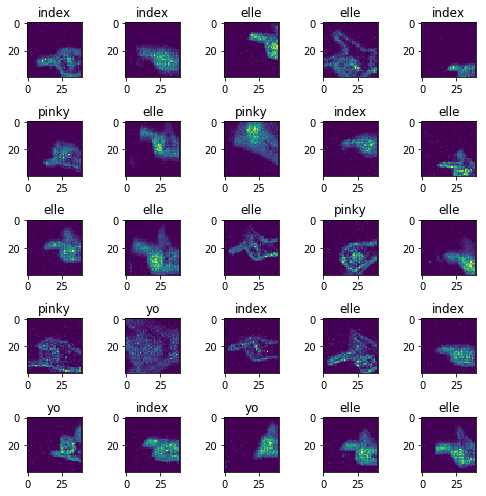

In [28]:
# Quick visual of dvs spikes
dvs = data['dvs']

fig, ax = plt.subplots(5, 5, figsize=(7, 7))

idx = np.random.permutation(len(dvs))[:25]

for i in range(5):
    for j in range(5):
        a = dvs[idx[i * 5 + j]]
        kkk = create_frame(a[1], a[0], dim=(40, 40))
        ax[i][j].imshow(kkk)
        ax[i][j].set_title(classes_inv[data['y'][idx[i * 5 + j]]])
plt.tight_layout()

# Quick test for info in spike traces

In [29]:
print(len(data['emg']))
print(data['emg'][0].shape)

1575
(3, 18948)


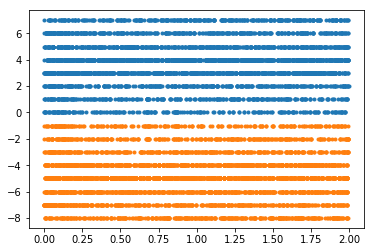

In [30]:
idx = 128
plt.plot(data['emg'][idx][1][data['emg'][idx][2] == 0], data['emg'][idx][0][data['emg'][idx][2] == 0], '.')
plt.plot(data['emg'][idx][1][data['emg'][idx][2] == 1], -1 * data['emg'][idx][0][data['emg'][idx][2] == 1] - 1, '.')

In [31]:
def spike_rate(ts, ch, frame_len=0.02, frame_step=0.01, n_ch=None):
    
    ts = np.array(ts)
    ch = np.array(ch)
    
    n_ch = max(list(set(ch))) if n_ch is None else n_ch
    
    ts -= ts[0]
    last_ts = ts[-1]
    
    n_win = int((last_ts - frame_len) // frame_step)
    rates = np.zeros((n_ch, n_win))
    for _ch in range(n_ch):
        _ts = ts[ch == _ch]
        
        for i in range(n_win):
            rates[_ch, i] = len(_ts[(_ts > i * frame_step) & (_ts <= i * frame_step + frame_len)]) / frame_len
    
    return rates

In [32]:
X = []
Y = []

for i in range(len(data['emg'])):
# for i in range(10):
    a = data['emg'][i]
    
    ts = copy.deepcopy(a[1][:])
    ch = copy.deepcopy(a[0][:])
    ch[a[2] == 0] += 8
    
    frame_len = 0.02
    frame_step = 0.01
    _to_add = spike_rate(ts, ch, n_ch=16, frame_len=frame_len, frame_step=frame_step).T
    n_win = int((2 / frame_step))
    if _to_add.shape[0] < n_win:
        _to_add = np.vstack([_to_add, np.zeros((n_win - _to_add.shape[0], _to_add.shape[1]))])
    _to_add = _to_add[:n_win]
    
    sep = _to_add.reshape(10, n_win // 10, 16)  # 200 ms
    sep = sep.reshape(10, 320)  # 200 ms
    X.append(sep)
    Y.append(np.ones((10,)) * data['y'][i])
    
X = np.concatenate(X, 0)
Y = np.concatenate(Y)
print(X.shape)
print(Y.shape)

(15750, 320)
(15750,)


In [ ]:
idx = np.random.permutation(len(X))
X = X[idx]
Y = Y[idx]

# pca
pca = PCA(8)
X = pca.fit_transform(X)
m = np.mean(X, 0, keepdims=True)
s = np.std(X, 0, keepdims=True)
X = (X - m) / s

print(X.shape)
n_train = int(len(X) * 0.8)
x_train = X[:n_train]
x_test = X[n_train:]
y_train = Y[:n_train]
y_test = Y[n_train:]

print(x_train.shape)

In [34]:
clf = SVC(gamma='auto', kernel='rbf', C=10)

clf.fit(x_train, y_train.ravel())
acc_te_out = clf.score(x_test, y_test.ravel())
acc_tr_out = clf.score(x_train, y_train.ravel())
print(acc_tr_out)
print(acc_te_out)

0.7621428571428571
0.6838095238095238


# ALL LINKS

The full spiking dataset (21 people) with 40x40 dvs crops and emg spikes can be found [HERE](https://www.dropbox.com/s/5q2aec6v32i6305/relax21_dvs_emg_spikes.pkl?dl=0). 

Worst case it can be generated again from the raw data by running this full notebook

The object is a pickle dictionary with the following keys:
    - dvs: list of samples, each sample contains the spikes for 2 seconds of one gesture. Each sample is a 4D tensor with dimensions corresponding to: address x, address y, timestamp, polarity.
    - emg: list of samples, each sample contains the spikes for 2 seconds of one gesture. Each sample is a 3D tensor with dimensions corresponding to: address, timestamp, polarity.
    - y: label (number) for each sample. For the text label look at the second cell of this notebook
    - sub: indicates the subject number of that gesture
    - ses: indicates the session number of that gesture